This notebook compares CASM dataset to in-situ soil moistiure measurements. 

To run it, you'll need to have CASM data and in-situ measurements.

Download the in-situ data from here [ISMN](https://ismn.geo.tuwien.ac.at/en/). Sample data is referenced in this notebook to check its functionality. 

Download CASM dataset from [ZENODO](https://doi.org/10.5281/zenodo.7072511). Sample data for May-December 2016 over Europe (Latitude: 36-54N, Longitude: 10W-35E) is referenced to check this notebook functionality.

In [31]:
# import packages 

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns



import warnings
warnings.filterwarnings('ignore')

import math

In [2]:
# CASM dataset goes here. Sample is used for the reference
file_CASM = '../some_data/CASM_sample_Europe2016.pkl'
db = pd.read_pickle(file_CASM)
db.head()

,lat,lon,date,CASM_soil_moisture
254993185,42.97,-3.761,2016-05-03,0.219399
254993243,42.97,-4.539,2016-05-03,0.317644
254993266,42.97,-4.020,2016-05-03,0.285719
254993349,42.97,-3.501,2016-05-03,0.222009
254993350,42.97,-2.983,2016-05-03,0.275169


In [3]:
db = db.dropna()
db = db.sort_values(by='date')
# start and end date of the sample
start_date = db['date'].values[1]
end_date = db['date'].values[-1]
print(start_date)
print(end_date)
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d')

2016-05-03T00:00:00.000000000
2016-12-29T00:00:00.000000000


In [4]:
# to use ISMN interface - use ismn package. Use the commented lines below to install it

#import sys
#!{sys.executable} -m pip install ismn
from ismn.interface import ISMN_Interface


# Sample data available
data_path = "../some_data/Data_separate_files_20160501_20161231_7160_YeIy_20220928.zip"
ismn_data = ISMN_Interface(data_path)

metadata_table = ismn_data.metadata

Found existing ismn metadata in python_metadata/Data_separate_files_20160501_20161231_7160_YeIy_20220928.csv.


In [5]:
count = 0
flag = 0 # set flag =1 if you want to save time series for individual stations

# how many data points are required. In the paper, used 100. Here for the sample data, use 30
num_valid = 30 
# column name of the CASM dataset with SM data
col_name = 'CASM_soil_moisture'
output_df = pd.DataFrame({'lat': [], 'lon': [], 'climate': [], 'cor': [],  'rmse':[], 'sample': [], 'station':[], 'network':[], 'sensor':[]} )

#iterating over in-situ data
for network, station, sensor in ismn_data.collection.iter_sensors(variable='soil_moisture',
                                                                  depth=[0., 0.05]):
    try: 
        data = sensor.read_data()
    except:
        #skip if data were not read
        continue
        
    data = data.reset_index()
    fullnum = data.shape[0]
    # only choose data with "GOOD" SM flag
    data1 = data[data['soil_moisture_flag']=='G']
    num = data1.shape[0]
    # only choose stations where at least 90% of the data have this flag
    if num/fullnum < 0.9:
        continue
    # only take SM data >0 (<0 is infeasible and should actually have "bad" flag)
    data = data1[data1['soil_moisture']>0]
    data['date'] = data['date_time'].dt.date
    # aggregate to the daily data if measured subdaily somewhere
    data = data.groupby(['date']).mean().reset_index()
    num = data.shape[0]
    # initial check for the number of datapoints (*3 because eventually the temporal resolution is 3-day)
    if num > 3*num_valid:
        meta = sensor.metadata.to_dict()
        net = network
        st = station
        sen = sensor
        
        lat = meta['latitude'][0][0] 
        lon = meta['longitude'][0][0]
        cl = meta['climate_KG'][0][0]

        # here create 3-day mean (rolling mean)
        data['3dm'] =  data['soil_moisture'].rolling(window=3).mean()
        data= data.dropna() 
        data = data[data['date']<=end_date]
        data = data[data['date']>=start_date]
        data['date'] =  pd.to_datetime(data['date'], infer_datetime_format=True)

        # find the closest CASM grid cell to the station    
        # lat_th is latitude initial threshold - the farthest grid cell that can be potentially taken for comparison 
        lat_th = 0.2   
        db_br_cst = db[np.abs(db['lat']-lat)<lat_th].copy()
        ll = db_br_cst['lat'].unique()
        # if there are more than 1 grid point within the threshold radius, choose the closest grid cell
        if len(ll)>1:
            lat_th = min(np.abs(ll-lat))  +0.0001
            db_br_cst = db[np.abs(db['lat']-lat)<lat_th].copy()  
            ll = db_br_cst['lat'].unique()
        if len(ll)<1:
            print('No CASM grid cell within the defined threshold for the station:')
            print(station.name)
            continue
 
        lon_th = 0.2 
        db_br_cst = db_br_cst[np.abs(db_br_cst['lon']-lon)<lon_th]
        ln = db_br_cst['lon'].unique()
        # same for the longitude
        if len(ln)>1:
            lon_th = min(np.abs(ln-lon))  +0.0001
            db_br_cst = db_br_cst[np.abs(db_br_cst['lon']-lon)<lon_th].copy()    
            ln = db_br_cst['lon'].unique()

        if len(ln)<1:
            print('No CASM grid cell within the defined threshold for the station:')
            print(station.name)
            continue    
        
        # merging CASM from the identified grid cell and in-situ data  
        compare = pd.merge(db_br_cst, data, on ='date')
        

        n = compare.shape[0]
        
        # if number of data points in the merged dataset is > than the defined minimum number
        if n > num_valid:
            # calculate correlation between CASM SM and in-situ SM
            cor = compare['3dm'].corr(compare[col_name])            
            unbiased_sm = compare['3dm'] - np.mean(compare['3dm'])
            unbiased_nn = compare[col_name]-np.mean(compare[col_name])
            # calculate RMSE and unbiased RMSE between CASM SM and in-situ SM
            rms = mean_squared_error(compare['3dm'], compare[col_name], squared=False)
            rms_un = mean_squared_error(unbiased_sm, unbiased_nn, squared=False)
           
            if np.isnan(cor):
                print('nan in correlation')
                print(compare.head())
                print(compare.shape)
                print(compare.isna().sum())
                
            if flag:    
                if cor <0.5:  # here I only want to see stations where correlation is low
                    if count < 40: # just a limit to make sure I don't have too many printouts

                        print('low correlation')
                        print(st)
                        print(station.name)
                        fig = plt.figure(figsize=(4, 3))
                        plt.plot(compare['date'], compare['3dm'], '.', markersize= 2, color = 'darkblue',  label = 'Site data')
                        plt.plot(compare['date'], compare[col_name], '.', markersize= 2, color = 'sandybrown', label = 'CASM SM' )
                        plt.xlabel('Date')
                        plt.ylabel('SM  $m^3/m^3$')
                        plt.legend()
                        path = '~/' # where to save the plots
                        name = path + station.name + '_' + str(round(cor, 2)) + '_' + str(count) +'.pdf'
                        plt.savefig(name, bbox_inches='tight')
                        plt.show()

            output_df_c = pd.DataFrame({'lat': [lat], 'lon': [lon], 'climate': [cl], 'cor': [cor],  'rmse':[rms], 'rmse_un':[rms_un], 'sample': [n], 'station':[st], 'network':[net], 'sensor':[sen]})   
            output_df = pd.concat([output_df, output_df_c])
            count = count+1

No CASM grid cell within the defined threshold for the station:
fraye
No CASM grid cell within the defined threshold for the station:
grandcal
No CASM grid cell within the defined threshold for the station:
hillan2
No CASM grid cell within the defined threshold for the station:
Berzeme
No CASM grid cell within the defined threshold for the station:
Gevenich
No CASM grid cell within the defined threshold for the station:
Gevenich
No CASM grid cell within the defined threshold for the station:
Gevenich
No CASM grid cell within the defined threshold for the station:
Merzenhausen
No CASM grid cell within the defined threshold for the station:
Merzenhausen
No CASM grid cell within the defined threshold for the station:
Schoeneseiffen


In [7]:
print("Total number of stations that satisfy the criteria: %2d" %count)
print('Mean correlation between CASM and in-situ SM measurements %5.3f'      %np.mean(output_df['cor']))
print('Median correlation between CASM and in-situ SM measurements %5.3f'    %np.median(output_df['cor'])) 
print('Mean RMSE %5.3f'      %np.mean(output_df['rmse']))
print('Mean unbiased RMSE %5.3f'      %np.mean(output_df['rmse_un']))


      

Total number of stations that satisfy the criteria: 51
Mean correlation between CASM and in-situ SM measurements 0.664
Median correlation between CASM and in-situ SM measurements 0.718
Mean RMSE 0.079
Mean unbiased RMSE 0.048


In [8]:
#save and read the data for further analysis
#output_df.to_csv('merged_CASM_insitu_for_comparison.csv', index = False)
#output_df = pd.read_csv('merged_CASM_insitu_for comparison.csv.csv')


Example analysis for an individual station

In [9]:
# read data from the individual station
data_st = ismn_data.collection['REMEDHUS']['CasaPeriles']['Stevens-Hydra-Probe_soil_moisture_0.000000_0.050000'] 
data_st

Stevens-Hydra-Probe_soil_moisture_0.000000_0.050000

In [10]:
# Station data with good flag and 3-day mean
ts = data_st.read_data()
ts = ts[ts['soil_moisture_flag']=='G']
ts = ts.reset_index()
ts['date'] = ts['date_time'].dt.date
ts = ts.sort_values(by='date')
ts['3dm'] =  ts['soil_moisture'].rolling(window=3).mean()
ts['date'] = pd.to_datetime(ts['date'], infer_datetime_format=True)
ts = ts.groupby(['date']).mean().reset_index()



In [11]:
lat = data_st.metadata['latitude'][1]
lon = data_st.metadata['longitude'][1] 

In [12]:
# CASM data from the closest grid cell
db_br_cst = db[np.abs(db['lat']-lat)<0.16].copy()
ll = db_br_cst['lat'].unique()
db_br_cst = db_br_cst[np.abs(db_br_cst['lon']-lon)<0.14]
ln = db_br_cst['lon'].unique()
print(ll)
print(ln)

[41.391]
[-5.317]


In [13]:
# sample smap data for comparison
file = '../some_data/SMAP_sample_2016.pkl' 
smap = pd.read_pickle(file)


In [14]:
smap_1 = smap[np.abs(smap['lat']-lat)<0.16].copy()
ll2 = smap_1['lat'].unique()
smap_1 = smap_1[np.abs(smap_1['lon']-lon)<0.14]
ln2 = smap_1['lon'].unique()

In [16]:
# merge CASM and in-situ data
compare = pd.merge(db_br_cst, ts, on ='date')

In [17]:
compare.head()

,lat,lon,date,CASM_soil_moisture,soil_moisture,3dm
0,41.391,-5.317,2016-05-06,0.203329,0.202583,0.198444
1,41.391,-5.317,2016-05-09,0.055892,0.169333,0.169347
2,41.391,-5.317,2016-05-12,0.197801,0.172292,0.172361
3,41.391,-5.317,2016-05-15,0.173849,0.151583,0.151806
4,41.391,-5.317,2016-05-18,0.078441,0.117292,0.117528


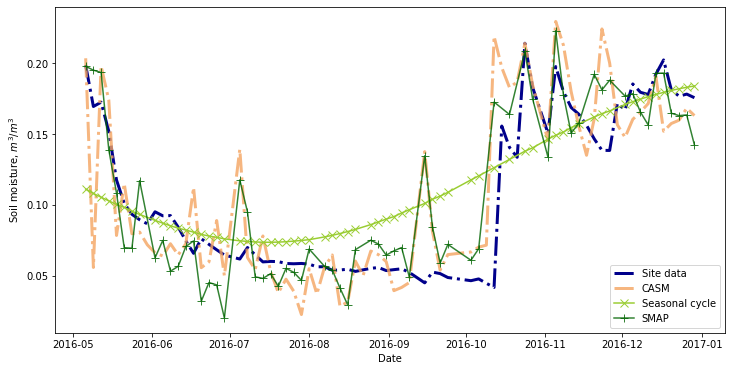

In [18]:
fig=plt.figure(figsize=(12, 6))

plt.plot(compare['date'], compare['3dm'], '-.',  linewidth = 3, color = 'darkblue',  label = 'Site data')
plt.plot(compare['date'], compare['CASM_soil_moisture'], '-.', alpha = 0.8, linewidth = 3, color = 'sandybrown',  label = 'CASM')
plt.plot(smap_1['date'], smap_1['sm_am_seas_med'], '-x', alpha = 1, markersize= 8, color='yellowgreen', label = 'Seasonal cycle')
plt.plot(smap_1['date'], smap_1['sm_am'], '-+', alpha = 0.8, markersize= 8, color='darkgreen', label = 'SMAP')


plt.legend()
plt.xlabel('Date')
plt.ylabel('Soil moisture, $m^3/m^3$')
#plt.savefig('CasaPeriles.pdf', bbox_inches='tight')


plt.show()



In [19]:
# merge CASM and SMAP data
comp_g1 = smap_1.merge(db_br_cst, on ='date',  how = 'outer')


In [22]:
print('CASM - SMAP correlation is %5.3f'  %comp_g1['sm_am'].corr(comp_g1['CASM_soil_moisture'] ))

CASM - SMAP correlation is 0.901


In [23]:
print('CASM - station correlation is %5.3f'  %compare['3dm'].corr(compare['CASM_soil_moisture'] ))

CASM - station correlation is 0.805


Maps and boxplots for the global comparison 

(here for the sample data only)

In [25]:
# an auxiliary column to have a color per climate

igbp = list(output_df["climate"].unique())

index = []
for val in output_df["climate"]:
    index.append(igbp.index(val))
output_df['color'] = index  

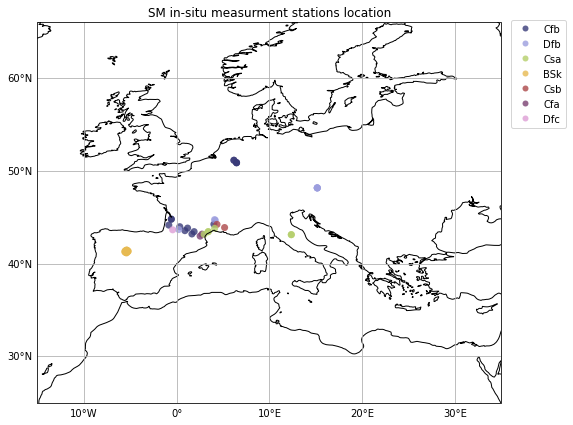

In [26]:
fig = plt.figure(figsize=(8.7, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#ax.set_global()
ax.set_extent([-15,35, 25,66], crs=ccrs.PlateCarree())
ax.coastlines()
gls = ax.gridlines(draw_labels=True)

sc = plt.scatter(x = output_df['lon'], y = output_df['lat'], c = output_df['color'], s = 50, alpha = 0.8, cmap=plt.cm.tab20b,  linewidth=0)
ax.legend(sc.legend_elements(num=len(igbp))[0], igbp, bbox_to_anchor=(1.01,1.02), loc="upper left")
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels
plt.title('SM in-situ measurment stations location')
#fig.savefig('s_station_loc.png', dpi = 200, bbox_inches='tight')
plt.show()

In [27]:
output_df['cor_b']=np.digitize(output_df['cor'],[0.4, 0.6, 0.8])

In [28]:
cmap = colors.ListedColormap(['red', 'orange', 'green', 'blue'])
bounds=[0,0.4,0.6, 0.8, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

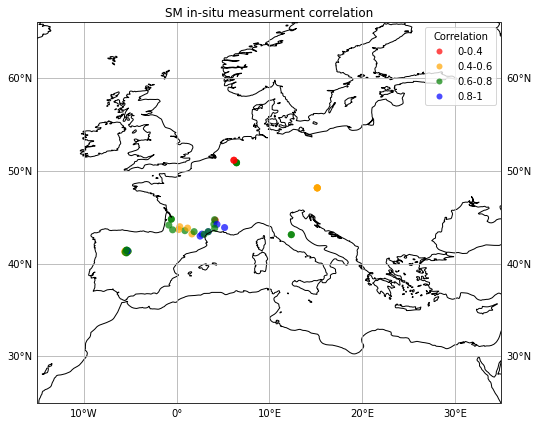

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#ax.set_global()
ax.set_extent([-15,35, 25,66], crs=ccrs.PlateCarree())

ax.coastlines()
gls = ax.gridlines(draw_labels=True)
gls.top_labels=False   # suppress top labels


sc = plt.scatter(x = output_df['lon'], y = output_df['lat'], c = output_df['cor_b'], s = 50, cmap=cmap, alpha = 0.7, linewidth=0)
ax.legend(sc.legend_elements()[0], ['0-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'], title="Correlation")
#plt.colorbar(sc, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 0.4, 0.6, 0.8, 1])
plt.title('SM in-situ measurment correlation')
#fig.savefig('station_cor.pdf')


plt.show()

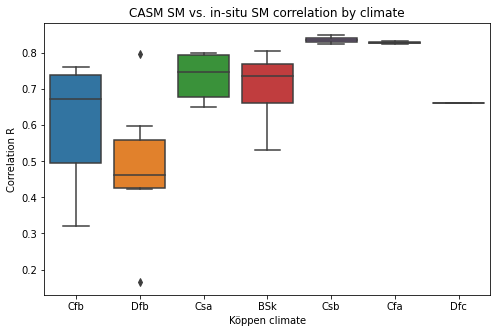

In [32]:
# boxplots per climate

fig = plt.figure(figsize=(8, 5))


sns.boxplot(x = output_df['climate'],
            y = output_df['cor'],
           order = list(output_df["climate"].unique()))
plt.title('CASM SM vs. in-situ SM correlation by climate')
plt.xlabel('Köppen climate')
plt.ylabel('Correlation R')
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#fig.savefig('in_situ_correl_box.pdf')



plt.show()

In [143]:
#full_short = full_out[~full_out.climate.isin(["Af","Am","BWh"])]

In [ ]:
# order for full datasets
# order = ['Af', 'Am', 'Aw', 'BWh', 'BWk', 'BSh', 'BSk',
#                      'Csa', 'Csb', 'Cwa', 'Cwb', 'Cfa', 'Cfb',
#                       'Dsb', 'Dfa', 'Dfb']

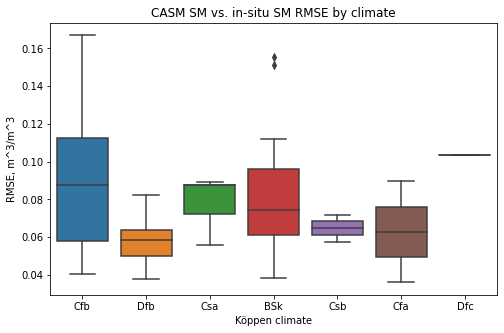

In [33]:
fig = plt.figure(figsize=(8, 5))


sns.boxplot(x = output_df['climate'],
            y = output_df['rmse'],
           order = list(output_df["climate"].unique()))
plt.title('CASM SM vs. in-situ SM RMSE by climate')
plt.xlabel('Köppen climate')
plt.ylabel('RMSE, m^3/m^3')


#plt.legend(loc = 'lower right')
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#fig.savefig('in_situ_rmse_box.pdf')



plt.show()